# Tonaton Scraper

#### Load Libraries

In [0]:
import re
import datetime
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

#### 1) Get information from the Property Page

In [0]:
def house_info(non_ad_houses):
    house_urls  = []
    house_names = []
    house_price = []
    house_beds  = []
    house_baths = []
    house_list_time = []
    for link in non_ad_houses:
    #     print(link.text)
        house_names.append(link.text.split(':')[0].title())
        house_urls.append(base_url + link.find('a').attrs['href'])
#         house_price.append(link.text.split('GH₵')[-1].split()[0])
        
        price = link.find('div', {'class': 'price--3SnqI color--t0tGX'}).span.text.replace('GH₵','').strip()
        beds  = link.find('div', {'class': 'content--3JNQz'}).div.div.text.split(',')[0].replace('Beds: ','').strip()
        baths = link.find('div', {'class': 'content--3JNQz'}).div.div.text.split(',')[1].replace('Baths: ','').strip()
    
        house_beds.append(beds)
        house_baths.append(baths)
        house_price.append(price)

    df_houses = pd.DataFrame({'Property Description': house_names, 
                              'Beds': house_beds, 
                              'Baths': house_baths, 
                              'Price (GH₵)': house_price, 
                              'Link': house_urls})
    
    return(df_houses)

def next_page(page_num, property_url, requests):
    next_url = property_url + '?by_paying_member=0&sort=date&order=desc&buy_now=0&page=' + str(page_num)
    result = requests.get(next_url)
    if result.status_code == 200:
        print('Scraping page number:', page_num)
    else:
        print('Error occured in page load')
        
    return result, requests, next_url

def gather_more_data(df):
    listing_broker = []
    listing_time = []
    
    for i in range(0,df.shape[0]):
        current_page = requests.get(df_final['Link'][i])
        src  = current_page.content
        soup = BeautifulSoup(src, 'html5lib')


        listing_broker.append(soup.find('span', {'class': 'poster'}).text.
                              replace('For sale by','').replace('MEMBER','').strip())
        
        date_time_str = soup.find('span', {'class': 'date'}).text
        date_time_obj = datetime.datetime.strptime(date_time_str, '%d %b %I:%M %p')
        
        date_time_obj = date_time_obj.replace(year=datetime.datetime.now().year)
        listing_time.append(date_time_obj)
    
    df['Listing Broker'] = listing_broker
    df['Listing Time'] = listing_time
    
    return df

def scape_newest_listing(df_saved_listings):
    current_page = requests.get('https://tonaton.com/en/ads/ghana/houses')
    src  = current_page.content
    soup = BeautifulSoup(src, 'html5lib')

    first_ad_house = soup.findAll('li', {'class': 'normal--2QYVk gtm-normal-ad first-add--1u5Mw'})
    non_ad_houses  = soup.findAll('li', {'class': 'normal--2QYVk gtm-normal-ad'})

    df_first_ad = house_info(first_ad_house)
    df_first_ad = gather_more_data(df_first_ad)
    
    df_non_ad_house = house_info(non_ad_houses)
    df_non_ad_house = gather_more_data(df_non_ad_house)
    
    latest_saved_listing_time = df_saved_listings['Listing Time'][0]
    
    if (df_non_ad_house['Listing Time'][0] > df_first_ad['Listing Time'][0]):
        latest_tontaton_listing_time = df_non_ad_house['Listing Time'][0]
    else:
        latest_tontaton_listing_time = df_first_ad['Listing Time'][0]
    
    if (latest_tontaton_listing_time > latest_saved_listing_time):
        print('Saved listings are not up to date.')
    else:
        print('Saved listings are up to date. There are no new listings as of:', datetime.datetime.now())

    return

def save_data(df):
    file_time = datetime.datetime.now()
    file_time = file_time.strftime('%Y-%m-%d')
    fine_name = 'tonaton_'+file_time+'.csv'
    
    df.to_csv('data/'+fine_name, index=False)

In [0]:
df_final = pd.DataFrame([])
df_first_ad = pd.DataFrame([])

base_url = 'https://tonaton.com'
result   = requests.get('https://tonaton.com/en/ads/ghana/houses')
property_url = result.url

# Enter the number of pages you would like to scrape
number_of_pages = 2

print('========================')
print('==== Scrape Tonaton ====')

for i in range(1, number_of_pages+1):
    df_first_ad = pd.DataFrame([])
    
    result, requests, next_url = next_page(i, property_url, requests)
    src  = result.content
    soup = BeautifulSoup(src, 'lxml')
    
    first_ad_house = soup.findAll('li', {'class': 'normal--2QYVk gtm-normal-ad first-add--1u5Mw'})
    non_ad_houses  = soup.findAll('li', {'class': 'normal--2QYVk gtm-normal-ad'})
    
    df_first_ad = house_info(first_ad_house)
    df = house_info(non_ad_houses)
    
    df_final = df_final.append(df)
    df_final = pd.concat([df_first_ad, df_final]).reset_index(drop=True) 
    
    df_final.reset_index(drop=True, inplace=True)
    
df_final['Price (GH₵)'] = df_final['Price (GH₵)'].str.replace(',','')
# df_final['Price (GH₵)'] = df_final['Price (GH₵)'].astype('int64')

# Add the listing time and listing broker
print('Now gathering additional information (Broker and Listing Time)...')
df_final = gather_more_data(df_final)
df_final = df_final.sort_values(by='Listing Time', ascending=False)

Newest_listing_time = df_final['Listing Time'][0]

print('\n')
print('Time of last listing posted:', Newest_listing_time)
    
save_data(df_final)

==== Scrape Tonaton ====
Scraping page number: 1
Scraping page number: 2
Now gathering additional information (Broker and Listing Time)...


Time of last listing posted: 2019-10-27 10:52:00


In [0]:
df_final

,Property Description,Beds,Baths,Price (GH₵),Link,Listing Broker,Listing Time
1,2 Bedroom House For Sale Lakesidebeds,2,1,250000,https://tonaton.com/en/ad/2-bedroom-house-for-...,Wisdom Estate Agency,2019-10-28 11:21:00
4,5 Bedroom Swimming Pool House For Sale East Ai...,5,6,2517580,https://tonaton.com/en/ad/5-bedroom-swimming-p...,Modern Properties Ghana,2019-10-28 10:54:00
5,4 Bedroom House For Sale At Spintexbeds,4,5,2470500,https://tonaton.com/en/ad/4-bedroom-house-for-...,Modern Properties Ghana,2019-10-28 10:50:00
7,80%Complete 4Bedroom House For Sale Ahenma Kok...,4,4,350000,https://tonaton.com/en/ad/80-percent-complete-...,Shelter Mart Property Services,2019-10-28 10:33:00
8,7 Bedrooms House At Dome_Kwabenyabeds,7,7,830000,https://tonaton.com/en/ad/7-bedrooms-house-at-...,Abena Properties,2019-10-28 09:53:00
9,Luxurious 4 Bedrm Self Compound Sale East Lego...,4,5,1911990,https://tonaton.com/en/ad/luxurious-4-bedrm-se...,Kingwode Properties,2019-10-28 08:56:00
11,7 Bedroom House On Over A 1 Plot Of Land For S...,7,7,1375000,https://tonaton.com/en/ad/7-bedroom-house-on-o...,Newmon Creek Limited,2019-10-28 03:32:00
12,5Br House At East Legon Hillsbeds,5,6,750000,https://tonaton.com/en/ad/5br-house-at-east-le...,Yaw Frimpong,2019-10-28 03:26:00
13,4 Bedroom For Sale At Abokobi (Adenta)Beds,4,4,700000,https://tonaton.com/en/ad/4-bedroom-for-sale-a...,Newmon Creek Limited,2019-10-28 03:04:00
15,3 Bedroom+Boys Quarters For Sale At Kwabenyabeds,3,3,550000,https://tonaton.com/en/ad/3-bedroomboys-quarte...,Newmon Creek Limited,2019-10-27 21:36:00


#### Method to Scrape the Newest Listing

In [0]:
scape_newest_listing(df_final)

Saved listings are up to date. There are no new listings as of: 2019-10-27 20:07:15.012455


#### Scratch

In [0]:
non_ad_houses  = soup.findAll('li', {'class': 'normal--2QYVk gtm-normal-ad'})

In [0]:
link.span.text

'4 Bedroom Uncompleted House for Sale at East Legon Hills'

In [0]:
link.find('div', {'class': 'content--3JNQz'}).div.div.text.split(',')[0].replace('Beds: ','').strip()

'4'

In [0]:
link.find('div', {'class': 'content--3JNQz'}).div.div.text.split(',')[1].replace('Baths: ','').strip()

'5'

<li class="normal--2QYVk gtm-normal-ad"><a class="card-link--3ssYv" href="/en/ad/4-bedroom-uncompleted-house-for-sale-at-east-legon-hills-for-sale-accra-2" title="4 Bedroom Uncompleted House for Sale at East Legon Hills"><div class="container--2uFyv"><div class="image--2hizm"></div><div class="content--3JNQz"><span class="title--3yncE">4 Bedroom Uncompleted House for Sale at East Legon Hills</span><div><div>Beds: 4, Baths: 5</div><div class="sub-title--1nbZO"><div class="membership-container--1hm7D"><div class="icon--3D09z extra-small--_AIuZ premium-icon--1q8GP"><svg class="svg-wrapper--8ky9e" height="18" viewbox="0 0 18 18" width="18"><g fill="none" fill-rule="evenodd"><circle cx="9" cy="9" fill="#FFC800" r="8.64"></circle><path d="M9 11.831L5.877 13.68l.828-3.467L3.96 7.88l3.62-.3L9 4.32l1.42 3.259 3.62.3-2.745 2.334.828 3.467z" fill="#FFF" fill-rule="nonzero"></path></g></svg></div><div class="premium-member--3Qd1D">MEMBER</div></div><div class="description--2-ez3">Accra, Houses</di
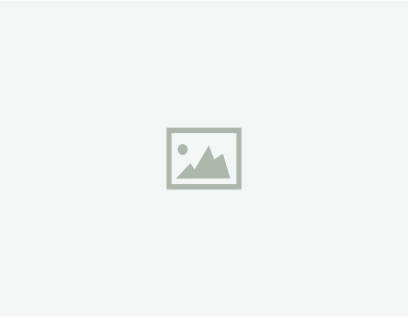

In [0]:
link

In [0]:
link.find('div', {'class': 'price--3SnqI color--t0tGX'}).span.text.replace('GH₵','').strip()

'350,000'

In [0]:
link.a.text

'4 Bedroom Uncompleted House for Sale at East Legon HillsBeds: 4, Baths: 5MEMBERAccra, HousesGH₵ 350,00015 hours'

In [0]:
import time